# Análisis de red (sectorial) de la economía española

El objetivo del presente notebook es analizar diferentes cuestiones de la red de sectores de la economía española. Cuestiones como ¿cuál es el sector **central** de la economía _(habrá que ver qué es central)_? o ¿Existen comunidades de sectores que estén estrechamente relacionadas pero "no" con los sectores ajenos? Para ello dividiremos en dos el análisis:
* 1. Centralidad
* 2. Comunidades  
 
 Todo el análisis lo basaremos en distintos módulos de una librería de Python llamada 'networkx', mientras que los enlaces (peso entre los nodos) serán aquellos calculados en A_out en el notebook anterior. (debido a que los shocks que estudiamos fueron los de demanda).
  
  Así, como ejemplo, si el sector de las telecomunicaciones vende el 30% de su output al sector ganadero y compra del ganadero el 15% del output de este, entre ambos sectores habrá dos enlaces: uno de Telecom a Ganadero con peso 0.30 y otro de Gandero a Telecom con 0.15.

Finalmente se hará una pequeña predicción de enlaces que, en nuestro caso, puede servir para ver qué enlaces serían susceptibles de existir, pero no lo hacen y por qué o simplemente para ver por qué son más susceptibles de existir y remarcar las conexiones entre dichos sectores.
  
 
 *NOTA*: Documentación de Networkx [AQUÍ](https://networkx.github.io/documentation/stable/index.html)





---

## 0. Creación del grafo

El grafo/red a crear tendrá como nodos los sectores y relaciones las explicitadas en el punto anterior. Los algoritmos no se basarán en la existencia o no de enlace, sino en el peso de estos, por lo que si el coeficiente de A_in es 0, se creará un enlace con peso nulo.


In [1]:
!pip install GraphRicciCurvature #instalar librería externa (solo una vez)
!pip install python-louvain #instalar librería externa (solo una vez)

     |████████████████████████████████| 2.0MB 4.0MB/s 
     |████████████████████████████████| 307kB 21.9MB/s 
  Created wheel for networkit: filename=networkit-6.1-cp36-cp36m-linux_x86_64.whl size=6782967 sha256=1434eef1996379b5710e2a41fcc9492fe9766ae097ec449c7642a07bfb27794b
  Stored in directory: /root/.cache/pip/wheels/ba/b3/ec/a2e42cc9d2c1639297237a483143437a53cd403bbc687872f5
Successfully built networkit


In [0]:
# import libraries
import community
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import random
import networkx as nx
import matplotlib as mpl
import io
import seaborn as sns
from google.colab import files
from GraphRicciCurvature.OllivierRicci import OllivierRicci
import math
import importlib
import datetime
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)
import plotly.graph_objects as go

In [0]:
print("SUBA EL ARCHIVO 'weights.csv'")
uploaded = files.upload()

SUBA EL ARCHIVO 'weights.csv'


MessageError: ignored

Ya tenemos cargada la matriz $\mathbf{A}$ que será la _matriz de adyacencia_ de nuestro grafo.

In [0]:
enlaces=pd.read_csv("weights.csv",delimiter=";")
enlaces=enlaces.set_index("ind")

In [0]:
enlaces

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
ind,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,871,0.1,0.0,0.2,"27,665.30",674.2,3.7,23.8,0.0,0,484.8,149.7,199.4,0,0,0,0.2,0,9.2,0,0.1,7.5,0,0,0,7.1,13.7,0,259.9,60.7,0,0.0,0,9.9,0,587.8,0.0,0,0,0,0.5,0.1,1.2,0,8.4,0,71.3,0,7.3,0,0.0,0,65.4,92.1,112.5,60.1,20.2,2.3,25.4,0.8,0.0,0.0,0,0
2,10.4,796.7,0.0,1.2,25.7,0,72.9,227,0.0,0,2.8,6.2,36.5,0,0,0,0.0,0,0.3,0,0,20.8,0,38.1,0,2.7,1.5,0,10.4,0.5,0,0.0,0,0,0,12.1,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0.8,8.6,0.0,0,0.0,0.3,0.0,0.0,0.0,0.0,0,0
3,0,0.0,44.6,0.0,203.3,0,0,0,0.0,0,0,0.1,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.3,0,2.6,0.3,0,0.0,0,0,0,3.5,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,6,21.3,5.9,9.5,0.3,0.0,0.0,0.0,0.0,0,0
4,0,0.0,3.0,53.1,94,2.6,0.3,71.3,1.7,"16,960.40",420,12.1,2.8,965.5,"2,091.30",102.1,0.3,445.3,22,77.8,0,7.8,32.3,"5,707.20",7.8,34.7,536,0.3,299.2,3.3,0.1,0.0,0,3.7,0,23.1,0.9,0.1,0.1,6.8,0.6,0.2,0.7,4.4,39.3,0.7,57.5,0.2,0,3.4,0.1,0,2.6,16.6,0.5,0,0.0,1.3,3.2,0.0,0.1,0.8,0,0
5,"7,371.80",0.7,164.3,20.5,"23,595.30",194.5,0.1,58.8,0.0,8.8,291.1,285,2,0.1,0,0.2,0.2,1.7,10.6,0,0,3.9,49.9,461,90.7,2.4,79.4,5.6,"1,110.90",606.4,8.6,0.0,0,36.9,0.5,"16,639.40",0.4,1.8,3.1,3.5,4.2,0.2,3.8,31.4,34.5,4.8,89.2,1.3,21.9,18.5,0.2,1.1,12.1,312.7,327.2,394.3,382.3,212.6,225.5,11.8,0.0,66.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,8,0.0,30.3,0.6,78.6,4.2,6.5,10.5,1.0,35.6,128.3,40.9,8.7,37.7,28.5,51.5,4.0,8.2,15.6,84.7,8.6,37.5,33.7,225.4,5.9,84.8,1,105.3,431.5,207,196.4,5.8,0,31.2,0.1,163.1,14.8,23.9,38.8,480.7,87.4,4.7,38.5,122.4,300.5,217.6,43.9,102.2,97.4,18.8,26.9,0,160.3,17.2,74.0,17.2,357.6,815.1,575.7,639.7,19.9,10.6,0,0
61,17.3,0.0,2.6,3.9,22.2,2.7,3.8,8.8,4.3,6.3,10.2,2.5,5.2,7.2,0,6.2,13.1,4.2,19.1,14.2,2,2.0,14.7,26.6,6.9,9.6,26.9,6.7,12.3,10.8,97.5,4.8,11.8,41.6,1.9,108.9,2.4,1.5,19.4,32.4,1.8,0.2,2.9,17.8,246.7,2,7.3,3.7,2.3,21.2,0.1,1.7,9.2,209.5,184.4,130.7,6.8,4.8,7.5,0.9,425.6,5.9,0,0
62,0,0.0,0.9,1.9,38.5,17.1,3,7.8,2.1,20.4,22.3,3.7,11,7.8,15,15,5.0,6.8,12.4,43.5,5.7,11.0,18.6,29.8,3.8,7.8,24,34.6,59.2,59.9,31.9,1.1,17.1,19.4,3.2,111.7,7.6,37.7,10.6,21.5,2.7,1.9,1.6,35.7,28.4,16.7,10.3,22.4,12.1,170.3,5.1,20.1,34.9,5,6.7,120.1,185.7,7.8,27.4,5.0,3.6,333.1,0,0


In [0]:
enlaces=enlaces.drop(63)
enlaces=enlaces.drop(64)
enlaces=enlaces.drop(47)
enlaces=enlaces.drop('63',axis=1)
enlaces=enlaces.drop('64',axis=1)
enlaces=enlaces.drop('47',axis=1)
# se eliminan los nodos sin enlaces

In [0]:
enlaces.head()[['1','2','3','4','5']] #pequeña muestra de A

,1,2,3,4,5
ind,,,,,
1,871,0.1,0.0,0.2,"27,665.30"
2,10.4,796.7,0.0,1.2,25.7
3,0,0.0,44.6,0.0,203.3
4,0,0.0,3.0,53.1,94
5,"7,371.80",0.7,164.3,20.5,"23,595.30"


In [0]:
# tenemos que pasar todo a float
for i in enlaces.index:
  for j in enlaces.columns:
    cad=str(enlaces[j][i])
    cad=cad.replace(",","")
    v=float(cad)
    enlaces[j][i]=v


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
enlacesCOM=enlaces.copy()
enlaces.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
ind,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,871,0.1,0.0,0.2,27665.3,674.2,3.7,23.8,0.0,0,484.8,149.7,199.4,0,0,0,0.2,0,9.2,0,0.1,7.5,0,0,0,7.1,13.7,0,259.9,60.7,0,0.0,0,9.9,0,587.8,0.0,0,0,0,0.5,0.1,1.2,0,8.4,0,0,7.3,0,0.0,0,65.4,92.1,112.5,60.1,20.2,2.3,25.4,0.8,0.0,0.0
2,10.4,796.7,0.0,1.2,25.7,0,72.9,227,0.0,0,2.8,6.2,36.5,0,0,0,0.0,0,0.3,0,0,20.8,0,38.1,0,2.7,1.5,0,10.4,0.5,0,0.0,0,0,0,12.1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.8,8.6,0.0,0,0.0,0.3,0.0,0.0,0.0,0.0
3,0,0.0,44.6,0.0,203.3,0,0,0,0.0,0,0,0.1,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.3,0,2.6,0.3,0,0.0,0,0,0,3.5,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,6,21.3,5.9,9.5,0.3,0.0,0.0,0.0,0.0
4,0,0.0,3.0,53.1,94,2.6,0.3,71.3,1.7,16960.4,420,12.1,2.8,965.5,2091.3,102.1,0.3,445.3,22,77.8,0,7.8,32.3,5707.2,7.8,34.7,536,0.3,299.2,3.3,0.1,0.0,0,3.7,0,23.1,0.9,0.1,0.1,6.8,0.6,0.2,0.7,4.4,39.3,0.7,0.2,0,3.4,0.1,0,2.6,16.6,0.5,0,0.0,1.3,3.2,0.0,0.1,0.8
5,7371.8,0.7,164.3,20.5,23595.3,194.5,0.1,58.8,0.0,8.8,291.1,285,2,0.1,0,0.2,0.2,1.7,10.6,0,0,3.9,49.9,461,90.7,2.4,79.4,5.6,1110.9,606.4,8.6,0.0,0,36.9,0.5,16639.4,0.4,1.8,3.1,3.5,4.2,0.2,3.8,31.4,34.5,4.8,1.3,21.9,18.5,0.2,1.1,12.1,312.7,327.2,394.3,382.3,212.6,225.5,11.8,0.0,66.0


In [0]:
G=nx.Graph() #creamos el grafo
for i in range(62):
  if (i!=47):
    G.add_node(i+1)
for i in range(62):
  if (i!=46):
    for j in range(62):
      if (j!=46):
        G.add_edge(i+1,j+1)
G=nx.DiGraph(G) #lo hacemos dirigido
# add weights a_ij=sales_ji/sales_i
# lo que busco es que A-w->B lo que vende A a B en w.

for ind1 in enlaces.index: 
    for ind2 in enlaces.index:
        G[ind1][ind2]['weight'] = enlaces[str(ind2)][ind1]

In [0]:
G[1][2] #works! 

{'weight': 0.1}

In [0]:
# Mejor eliminamos los enlaces con peso 0
for i in range(62):
  if (i!=46):
    for j in range(62):
      if (j!=46):
        if G[i+1][j+1]['weight']==0:
            G.remove_edge(i+1,j+1)

In [0]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 62
Number of edges: 3315
Average in degree:  53.4677
Average out degree:  53.4677


Ya tenemos el grafo. Vamos a **representar** un subgrafo (un poco al azar) de tal manera que pueda verse la forma del mismo. Los colores indican, cuanto más oscuro, más relación entre sectores. 
 
 En este se ve bien cómo son las relaciones en la red: hay nodos que se relacionan bilateralmente (12,13) o (11,12), unilateralmente (10,13) o que no se relacionan (10,12).

In [0]:
subG=G.subgraph([10,11,12,13])

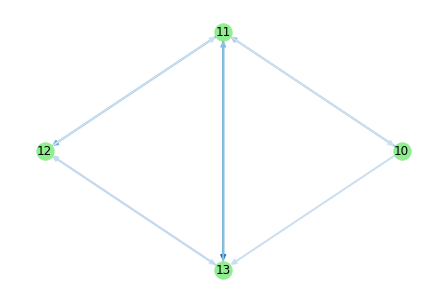

In [0]:
edges,weights = zip(*nx.get_edge_attributes(subG,'weight').items())
weights=np.array(weights)

cmap = mpl.cm.Blues(np.linspace(0,3,150))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

nx.draw_circular(subG, node_color='lightgreen', edgelist=edges, edge_color=weights, width=2.0, edge_cmap=cmap, with_labels = True)
plt.savefig('edges.png')

## 1. Centralidad
Hay distintas maneras de medir la **centralidad**, calcularemos 'pagerank', 'grado', 'eigenvector' y las interpretaremos.

### 1.1. Grado
El grado normalmente mide el número de vecinos **directos** que tiene un nodo. En el caso de un grafo con pesos y dirigido como el nuestro, hay tres métricas para el grado: el grado entrante _(indegree)_ que es la suma de todos los pesos de enlaces con destino el nodo para el que se calcula, el grado saliente _(outdegree)_, que es el análogo siendo el nodo el de origen; y lo que podemos llamar grado, que es la suma de los anteriores. Así, los computamos y creo un DataFrame con los resultados.

In [0]:
degree=pd.DataFrame()
degree['index']=range(1,63)
degree=degree.set_index('index')
indg=[]
outdg=[]
tdg=[]
windg=[]
woutdg=[]   #every type of degree
wtdg=[]
a=list(G.in_degree)
b=list(G.out_degree)
c=list(G.in_degree(weight='weight'))
d=list(G.out_degree(weight='weight'))
for i in range(0,62):
    indg.append(a[i][1])
    outdg.append(b[i][1])
    tdg.append(a[i][1]+b[i][1])
    windg.append(round(c[i][1],3))
    woutdg.append(round(d[i][1],3))
    wtdg.append(round(c[i][1]+d[i][1],3))
degree["InDegree"]=indg
degree["OutDegree"]=outdg
degree["TotDegree"]=tdg
degree["WInDegree"]=windg
degree["WOutDegree"]=woutdg
degree["WTotDegree"]=wtdg

In [0]:
degree.head()

,InDegree,OutDegree,TotDegree,WInDegree,WOutDegree,WTotDegree
index,,,,,,
1,45,33,78,20175.1,31424.6,51599.7
2,18,20,38,960.5,1275.5,2236.0
3,54,12,66,1165.7,297.7,1463.4
4,58,50,108,2007.8,28063.7,30071.5
5,59,54,113,87776.3,53176.5,140952.8


Con los resultados, podemos ver qué sectores tienen **mayor grado** tipo IN y tipo OUT, así como una **distribución** aproximada de cada uno de los grados en para los nodos del grafo.

* Para el grado-in:

In [0]:
degree.sort_values("WInDegree",ascending=False).head()

,InDegree,OutDegree,TotDegree,WInDegree,WOutDegree,WTotDegree
index,,,,,,
5,59,54,113,87776.3,53176.5,140952.8
27,61,61,122,65361.2,33205.3,98566.5
29,60,61,121,53280.3,51512.1,104792.4
20,55,50,105,51183.8,23939.0,75122.8
36,61,60,121,46699.1,12885.2,59584.3


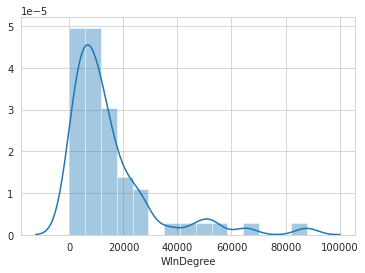

In [0]:
sns.distplot(degree['WInDegree']);
plt.savefig('idegdist.eps', format='eps')

* Para el grado-out

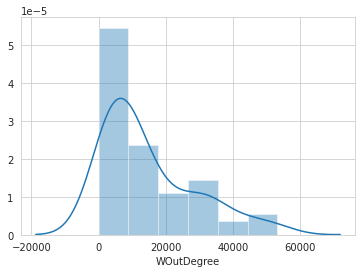

In [0]:
sns.distplot(degree['WOutDegree']);
plt.savefig('odegdist.eps', format='eps')

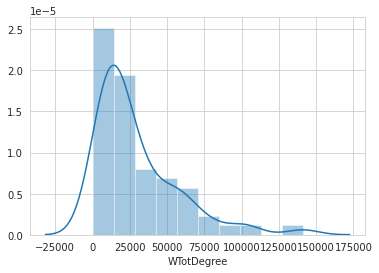

In [0]:
# para el grado total
sns.distplot(degree['WTotDegree']);
plt.savefig('degdist.eps', format='eps')

In [0]:
principales = degree['WInDegree'].to_frame()[0:62] # nos quedamos para comparar con 
                                    # otros algoritmos la centralidad total

## 1.2. Eigenvector

La centralidad **Eigenvector** es otro tipo de centralidad que se basa en el autovalor de la matriz de adyacencia (en nuestro caso, $\mathbf{A}$).

In [0]:
a=nx.eigenvector_centrality(G, max_iter=100000, tol=1e-06, nstart=None, weight='weight')
ac=[]
for i in range(1,63):
    ac.append(round(a[i],4))
principales["EigenVector"]=ac

* Añadimos los resultados a los anteriores:

In [0]:
principales.head()

,WInDegree,EigenVector
index,,
1,20175.1,0.2110
2,960.5,0.0002
3,1165.7,0.0049
4,2007.8,0.0018
5,87776.3,0.8357


* Distribución de los resultados del Eigenvector:

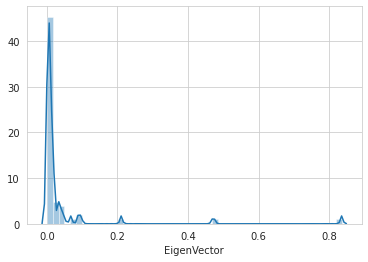

In [0]:
sns.distplot(principales['EigenVector']);

In [0]:
principales.sort_values("EigenVector")

,WInDegree,EigenVector
index,,
47,0.0,0.0000
2,960.5,0.0002
51,12103.1,0.0003
32,1187.2,0.0006
61,3069.8,0.0006
...,...,...
27,65361.2,0.0892
52,15306.1,0.0967
1,20175.1,0.2110


### 1.3 PageRank
El último tipo de centralidad que mediremos será la que viene dada por el algoritmo _PageRank_.

In [0]:
pr=nx.pagerank(G, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)
ac=[]
for i in range(1,63):
    ac.append(round(pr[i],4))
principales["PageRank"]=ac

* Añadimos los resultados a la tabla global:

In [0]:
principales.head()

,WInDegree,EigenVector,PageRank
index,,,
1,20175.1,0.2110,0.0214
2,960.5,0.0002,0.0056
3,1165.7,0.0049,0.0046
4,2007.8,0.0018,0.0039
5,87776.3,0.8357,0.0732


### 1.4 Conclusión y Análisis

Hemos utilizado distintos métodos para medir la centralidad, pues ésta no puede definirse unívocamente. Antes de entrar a diferenciar los matices entre estos y explicar los resultados obtenidos, debemos preguntarnos si -en la práctica- los resultados entre los métodos difieren. Para ello utilizamos la correlación de Spearman (basada en el ranking/orden de los resultados, que es en lo que nos fijaremos). 

In [0]:
principales.corr(method="spearman")

,WInDegree,EigenVector,PageRank
WInDegree,1.000000,0.762890,0.797789
EigenVector,0.762890,1.000000,0.897726
PageRank,0.797789,0.897726,1.000000


Como vemos, la correlación es bastante mayor entre EigenVector y PageRank y, para los pocos datos que hay, la correlación es suficientemente alta. _(Spearman tiende a crear "falsas" correlaciones >0.999 simplemente por la magnitud de los datos y el peso de esa $n$ en su cálculo)_. 
 
 Por tanto, ahora pasamos a **analizar los resultados obtenidos**, obteniendo los cinco sectores más centrales para EigenVector y PageRank, como hicimos con el grado.

In [0]:
# EIGENVECTOR
principales.sort_values("EigenVector",ascending=False)

,WInDegree,EigenVector,PageRank
index,,,
5,87776.3,0.8357,0.0732
36,46699.1,0.4721,0.0468
1,20175.1,0.2110,0.0214
52,15306.1,0.0967,0.0522
27,65361.2,0.0892,0.0746
...,...,...,...
61,3069.8,0.0006,0.0041
32,1187.2,0.0006,0.0035
51,12103.1,0.0003,0.0031


In [0]:
# PAGERANK
principales.sort_values("PageRank",ascending=False)

,WInDegree,EigenVector,PageRank
index,,,
27,65361.2,0.0892,0.0746
5,87776.3,0.8357,0.0732
20,51183.8,0.0491,0.0634
52,15306.1,0.0967,0.0522
36,46699.1,0.4721,0.0468
...,...,...,...
17,2495.2,0.0014,0.0040
4,2007.8,0.0018,0.0039
32,1187.2,0.0006,0.0035


In [0]:
# DEGREE
degree.sort_values("WTotDegree",ascending=False).head()

,InDegree,OutDegree,TotDegree,WInDegree,WOutDegree,WTotDegree
index,,,,,,
5,59,54,113,87776.3,53176.5,140952.8
29,60,61,121,53280.3,51512.1,104792.4
27,61,61,122,65361.2,33205.3,98566.5
24,49,61,110,36945.6,44295.1,81240.7
20,55,50,105,51183.8,23939.0,75122.8


## 2. Comunidades
Para detectar las **'comunidades de sectores'** utilizaremos dos algoritmos, el _label propagation_, muy extendido y basado en la modularidad y uno novedoso(jul 2019) que parece batir con frecuencia las métricas de cualquier otro, basado en la curvatura de Ricci.
 
 A pesar de haber varios algoritmos ya implementados en la libería de networkx, no lo están para grafos dirigidos con peso, por lo que nuestra capacidad de elección -sin salirse fuera de la libería- es escasa. Por tanto, posteriormente debemos pasar a un **grafo sin direccionalidad**, aunque perdamos dicha información (muy relevante), para acercarnos a una estructura de comunidades.  
______________

  
  _Nota: Lo que siempre necesitaremos es un algoritmo que tenga en cuenta los pesos de los enlaces, pues es nuestra fuente de información principal._

### 2.1. Label Propagation

Este algoritmo no es demasiado sofisticado, por lo que es muy personalizable y nos permite su computación para un grafo dirigido y con peso.

In [0]:
a=list(nx.algorithms.community.label_propagation.asyn_lpa_communities(G,weight='weight'))
com_lp=pd.DataFrame()
com_lp["Comunidad"]=range(len(a))
ac=[]
for i in a:
  ac.append(list(i))
com_lp["Sectores"]=ac

In [0]:
com_lp

,Comunidad,Sectores
0,0,"[1, 3, 4, 5, 8, 9, 10, 11, 13, 17, 19, 23, 24,..."
1,1,[2]
2,2,[6]
3,3,[7]
4,4,"[56, 12, 22]"
5,5,"[46, 18, 27, 14]"
6,6,"[16, 20, 15]"
7,7,[21]
8,8,[26]
9,9,"[33, 36, 52]"


In [0]:
print("Hay una comunidad de "+str(len(com_lp["Sectores"][0]))+" sectores")

Hay una comunidad de 41 sectores


### 2.2. Grafo Sin Direccionalidad: Ricci y Louvain

#### 2.2.1. Creación del Grafo Sin Direccionalidad

In [0]:
enlaces

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
ind,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,871,0.1,0.0,0.2,27665.3,674.2,3.7,23.8,0.0,0,484.8,149.7,199.4,0,0,0,0.2,0,9.2,0,0.1,7.5,0,0,0,7.1,13.7,0,259.9,60.7,0,0.0,0,9.9,0,587.8,0.0,0,0,0,0.5,0.1,1.2,0,8.4,0,0,7.3,0,0.0,0,65.4,92.1,112.5,60.1,20.2,2.3,25.4,0.8,0.0,0.0
2,10.4,796.7,0.0,1.2,25.7,0,72.9,227,0.0,0,2.8,6.2,36.5,0,0,0,0.0,0,0.3,0,0,20.8,0,38.1,0,2.7,1.5,0,10.4,0.5,0,0.0,0,0,0,12.1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.8,8.6,0.0,0,0.0,0.3,0.0,0.0,0.0,0.0
3,0,0.0,44.6,0.0,203.3,0,0,0,0.0,0,0,0.1,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.3,0,2.6,0.3,0,0.0,0,0,0,3.5,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,6,21.3,5.9,9.5,0.3,0.0,0.0,0.0,0.0
4,0,0.0,3.0,53.1,94,2.6,0.3,71.3,1.7,16960.4,420,12.1,2.8,965.5,2091.3,102.1,0.3,445.3,22,77.8,0,7.8,32.3,5707.2,7.8,34.7,536,0.3,299.2,3.3,0.1,0.0,0,3.7,0,23.1,0.9,0.1,0.1,6.8,0.6,0.2,0.7,4.4,39.3,0.7,0.2,0,3.4,0.1,0,2.6,16.6,0.5,0,0.0,1.3,3.2,0.0,0.1,0.8
5,7371.8,0.7,164.3,20.5,23595.3,194.5,0.1,58.8,0.0,8.8,291.1,285,2,0.1,0,0.2,0.2,1.7,10.6,0,0,3.9,49.9,461,90.7,2.4,79.4,5.6,1110.9,606.4,8.6,0.0,0,36.9,0.5,16639.4,0.4,1.8,3.1,3.5,4.2,0.2,3.8,31.4,34.5,4.8,1.3,21.9,18.5,0.2,1.1,12.1,312.7,327.2,394.3,382.3,212.6,225.5,11.8,0.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,1,0.0,1.5,0.1,20.1,0.2,0.1,0,4.5,7,6.4,11.7,0,0,0.2,0,2.7,0,7.3,18.1,4,0.2,39.6,0,0.1,0.6,0.2,0.6,99.9,10.3,32.8,0.0,20.2,0,17.3,242.6,62.7,53.1,49.9,0.3,26.4,3,11.8,8.3,107.2,86,109.8,74.3,46.7,14.0,93.4,135.7,10.5,6.1,0,0.0,432.4,215.8,4.3,0.7,17.0
59,0,0.0,0.7,0.1,63.2,7.2,0,4.1,4.6,74.7,8.7,8,10.5,0,15,9.5,13.6,0.1,20.3,44,50.8,37.9,67.5,0,0.2,13.9,0.6,53,580.3,14,0,0.0,0,73.7,49.7,174.7,130.4,102.5,176,0.6,90.6,9.2,40.1,92.2,137.8,38.9,179.7,144.1,101.6,27.9,401.2,227.1,30.4,14.7,0,3.9,953.5,878.3,99.6,6.0,2.8
60,8,0.0,30.3,0.6,78.6,4.2,6.5,10.5,1.0,35.6,128.3,40.9,8.7,37.7,28.5,51.5,4.0,8.2,15.6,84.7,8.6,37.5,33.7,225.4,5.9,84.8,1,105.3,431.5,207,196.4,5.8,0,31.2,0.1,163.1,14.8,23.9,38.8,480.7,87.4,4.7,38.5,122.4,300.5,217.6,102.2,97.4,18.8,26.9,0,160.3,17.2,74.0,17.2,357.6,815.1,575.7,639.7,19.9,10.6


In [0]:
enlaces=pd.read_csv("A_out_com.csv",delimiter=",")
enlaces=enlaces.set_index("ind")
enlaces=enlaces.drop(63)
enlaces=enlaces.drop(64)
enlaces=enlaces.drop('63',axis=1)
enlaces=enlaces.drop('64',axis=1)
enlaces

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
ind,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.027654,0.000003,0.000000,0.000006,0.878378,0.021406,0.000117,0.000756,0.000000,0.000000,0.015392,0.004753,0.006331,0.000000,0.000000,0.000000,0.000006,0.000000,0.000292,0.000000,0.000003,0.000238,0.000000,0.000000,0.000000,0.000225,0.000435,0.000000,0.008252,0.001927,0.000000,0.000000,0.000000,0.000314,0.000000,0.018663,0.000000,0.000000,0.000000,0.000000,0.000016,0.000003,0.000038,0.000000,0.000267,0.000000,0.002264,0.000000,0.000232,0.000000,0.000000,0.000000,0.002076,0.002924,0.003572,0.001908,0.000641,0.000073,0.000806,0.000025,0.000000,0.000000
2,0.008154,0.624618,0.000000,0.000941,0.020149,0.000000,0.057154,0.177969,0.000000,0.000000,0.002195,0.004861,0.028616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000235,0.000000,0.000000,0.016307,0.000000,0.029871,0.000000,0.002117,0.001176,0.000000,0.008154,0.000392,0.000000,0.000000,0.000000,0.000000,0.000000,0.009486,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000627,0.006742,0.000000,0.000000,0.000000,0.000235,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.149815,0.000000,0.682902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001008,0.000000,0.008734,0.001008,0.000000,0.000000,0.000000,0.000000,0.000000,0.011757,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020155,0.071549,0.019819,0.031911,0.001008,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000107,0.001888,0.003343,0.000092,0.000011,0.002535,0.000060,0.603118,0.014935,0.000430,0.000100,0.034334,0.074367,0.003631,0.000011,0.015835,0.000782,0.002767,0.000000,0.000277,0.001149,0.202950,0.000277,0.001234,0.019060,0.000011,0.010640,0.000117,0.000004,0.000000,0.000000,0.000132,0.000000,0.000821,0.000032,0.000004,0.000004,0.000242,0.000021,0.000007,0.000025,0.000156,0.001398,0.000025,0.002045,0.000007,0.000000,0.000121,0.000004,0.000000,0.000092,0.000590,0.000018,0.000000,0.000000,0.000046,0.000114,0.000000,0.000004,0.000028
5,0.138397,0.000013,0.003085,0.000385,0.442974,0.003652,0.000002,0.001104,0.000000,0.000165,0.005465,0.005351,0.000038,0.000002,0.000000,0.000004,0.000004,0.000032,0.000199,0.000000,0.000000,0.000073,0.000937,0.008655,0.001703,0.000045,0.001491,0.000105,0.020856,0.011384,0.000161,0.000000,0.000000,0.000693,0.000009,0.312385,0.000008,0.000034,0.000058,0.000066,0.000079,0.000004,0.000071,0.000589,0.000648,0.000090,0.001675,0.000024,0.000411,0.000347,0.000004,0.000021,0.000227,0.005871,0.006143,0.007403,0.007177,0.003991,0.004233,0.000222,0.000000,0.001239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.000470,0.000000,0.000705,0.000047,0.009450,0.000094,0.000047,0.000000,0.002116,0.003291,0.003009,0.005501,0.000000,0.000000,0.000094,0.000000,0.001269,0.000000,0.003432,0.008510,0.001881,0.000094,0.018619,0.000000,0.000047,0.000282,0.000094,0.000282,0.046970,0.004843,0.015422,0.000000,0.009497,0.000000,0.008134,0.114063,0.029480,0.024966,0.023461,0.000141,0.012412,0.001411,0.005548,0.003902,0.050402,0.040434,0.003855,0.051624,0.034933,0.021957,0.006582,0.043914,0.063802,0.004937,0.002868,0.000000,0.000000,0.203301,0.101462,0.002022,0.000329,0.007993
59,0.000000,0.000000,0.000132,0.000019,0.011912,0.001357,0.000000,0.000773,0.000867,0.014079,0.001640,0.001508,0.001979,0.000000,0.002827,0.001

Creamos un grafo sin direccionalidad ni pesos para poder calcular comunidades con otros algoritmos, aunque perdamos esta información, que es relevante. Aún así, llegamos a comunidades de sectores interrelacionados.

In [0]:

Gud=nx.Graph() #creamos el grafo
for i in range(62):
    Gud.add_node(i+1)
for i in range(62):
    for j in range(62):
        Gud.add_edge(i+1,j+1)

# sumamos los pesos de los enlaces antiguos
maxim=0
minim=99999

for ind1 in enlaces.index: 
    for ind2 in enlaces.index:
        Gud[ind1][ind2]['weight'] = enlaces[str(ind2)][ind1]+enlaces[str(ind1)][ind2]
        if maxim<enlaces[str(ind2)][ind1]+enlaces[str(ind1)][ind2]:
          maxim=enlaces[str(ind2)][ind1]+enlaces[str(ind1)][ind2]
        if minim>enlaces[str(ind2)][ind1]+enlaces[str(ind1)][ind2]:
          minim=enlaces[str(ind2)][ind1]+enlaces[str(ind1)][ind2]

# Mejor eliminamos los enlaces con peso 0
maxim=0
minim=9999
for i in range(62):
    for j in range(62):
        try:
          if Gud[i+1][j+1]['weight']==0:
              Gud.remove_edge(i+1,j+1)
          else:
              if maxim<Gud[i+1][j+1]['weight']:
                  maxim=Gud[i+1][j+1]['weight']
              if minim>Gud[i+1][j+1]['weight']:
                  minim=Gud[i+1][j+1]['weight']

        except:
          bluf=0

#normalizo entre 0 y 1, para aumentar la varianza en los algoritmos
for i in range(62):
    for j in range(62):
        try:
          Gud[i+1][j+1]['weight']=(Gud[i+1][j+1]['weight']-minim)/(maxim-minim)

        except:
          bluf=0

Para la curvatura de Ricci debemos eliminar los enlaces menos relevantes, entendiendo estos como aquellos con menor peso. Para ello, vemos la distribución del peso de los enlaces en su parte inferior.

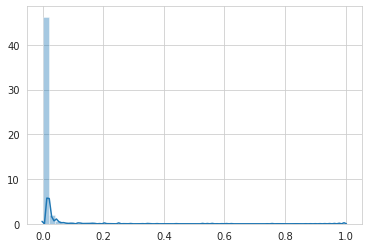

In [0]:
ac=[]
for i in range(62):
  for j in range(62):
    try:
      ac.append(Gud[i+1][j+1]['weight'])
    except:
      bluf=0
ar=np.array(ac)
sns.distplot(ar);

Así, eliminamos todos aquellos enlaces con peso por debajo de 0.011 para _aligerar_ computacionalmente la curvatura de Ricci.

In [0]:
Gred=Gud.copy() #Gred: G REDucido, copia de Gud: G UnDirected
count=0
for i in range(62):
    for j in range(62):
        try:
          if Gred[i+1][j+1]['weight']<0.011:
              Gred.remove_edge(i+1,j+1)
              count=count+1
        except:
          bluf=-1
print("Eliminados "+str(count)+" enlaces.")

Eliminados 1543 enlaces.


#### 2.2.2. Curvatura de Ricci

La idea de utilizar la curvatura de Ricci para detectar comunidades es la de la imagen. Un pequeño tutorial está en el siguiente [enlace](https://colab.research.google.com/github/saibalmars/GraphRicciCurvature/blob/master/notebooks/tutorial.ipynb#scrollTo=aPJtnKPD4XeC). 

![Idea](https://raw.githubusercontent.com/saibalmars/GraphRicciCurvature/master/resources/karate_demo.png)

**Realizamos la curvatura de Ricci** para el nuevo grafo reducido (Gred), del cual vemos primero su **información básica**. 
 
 Además, debemos **eliminar los _self loops_**, es decir, los enlaces a sí mismos, ya que el algoritmo no los permite.

In [0]:
count=0
for i in range(62):
    try:
      Gred.remove_edge(i+1,i+1)
      count=count+1
    except:
      bluf=-1
print("Eliminados "+str(count)+" enlaces.")

Eliminados 57 enlaces.


In [0]:
print(nx.info(Gred))

Name: 
Type: Graph
Number of nodes: 62
Number of edges: 289
Average degree:   9.3226


_La siguiente celda son únicamente definiciones de funciones y la podemos obviar:_

In [0]:
######################################
##    OBVIAR: solo son funciones    ##
######################################

def hora():
      an=datetime.datetime.now().year
      me=datetime.datetime.now().month
      di=datetime.datetime.now().day
      ho=datetime.datetime.now().hour
      mi=datetime.datetime.now().minute
      se=datetime.datetime.now().second
      print("Hora y Fecha: "+str(ho)+":"+str(mi)+":"+str(se)+" ("+str(di)+"/"+str(me)+"/"+str(an)+")")


def riccicomplete(G,iter,boolean): #tres parametros: Grafo, iteraciones y 
                                   #si queremos los resultados de la curvatura
                                   # (True) o solo los del flujo
  print("##############################")
  print("#    PROCESO EN EJECUCIÓN    #")
  print("##############################")

  print()
  hora()
  print()
  if boolean:
    print("1. CALCULAMOS LA CURVATURA: ")
    print()
    orc = OllivierRicci(Gred, alpha=0.5, verbose="INFO")
    orc.compute_ricci_curvature()
    G_orc=orc.G.copy()
    print("1.2. RESULTADOS DE LA CURVATURA: ")
    show_results(G_orc)
  else:
    print("CALCULO DE CURVATURA OBVIADO")
  print()
  print("2. CALCULAMOS EL FLUJO: ")
  print()
  orf = OllivierRicci(G, alpha=0.75, base=math.e, exp_power=0, proc=4, verbose="INFO")
  orf.set_verbose("ERROR") # mute logs
  orf.compute_ricci_flow(iterations=20)
  G_rf = orf.G.copy()
  print("2.2. RESULTADOS DEL FLUJO: ")
  print()
  show_results(G_rf)
  print()
  hora()
  print()
  print("##############################")
  print("#       FIN DEL PROCESO      #")
  print("##############################")
  return G_rf

def show_results(G): #muestra resultados
    # Print the first five results
    print("Graph, first 5 edges: ")
    for n1,n2 in list(G.edges())[:5]:
        print("Ollivier-Ricci curvature of edge (%s,%s) is %f" % (n1 ,n2, G[n1][n2]["ricciCurvature"]))

    # Plot the histogram of Ricci curvatures
    plt.subplot(2, 1, 1)
    ricci_curvtures = nx.get_edge_attributes(G, "ricciCurvature").values()
    plt.hist(ricci_curvtures,bins=20)
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Ricci Curvatures ")

    # Plot the histogram of edge weights
    plt.subplot(2, 1, 2)
    weights = nx.get_edge_attributes(G, "weight").values()
    plt.hist(weights,bins=20)
    plt.xlabel('Edge weight')
    plt.title("Histogram of Edge weights ")

    plt.tight_layout()

def my_surgery(G_origin: nx.Graph(), weight="weight", cut=0): #crea cortes
    """
    A simple surgery function that remove the edges with weight above a threshold
    :param G: A weighted networkx graph
    :param weight: Name of edge weight to cut
    :param cut: Manually assign cut point
    :return: A weighted networkx graph after surgery
    """
    G=G_origin.copy()
    w = nx.get_edge_attributes(G, weight)

    assert cut >=0, "Cut value should be greater than 0."
    if not cut:
        cut = (max(w.values()) - 1.0) * 0.6 + 1.0  # Guess a cut point as default
    
    to_cut = []
    for n1, n2 in G.edges():
        if G[n1][n2][weight] > cut:
            to_cut.append((n1, n2))
    print("*************** Surgery time ****************")
    print("* Cut %d edges." % len(to_cut))
    G.remove_edges_from(to_cut)
    print("* Number of nodes now: %d" % G.number_of_nodes())
    print("* Number of edges now: %d" % G.number_of_edges())
    cc=list(nx.connected_components(G))
    print("* Modularity now: %f " % nx.algorithms.community.modularity(G,cc))
    print("*********************************************")
    
    return G

def draw_graph(G,grosor): #dibuja el grafo
    edges=G.edges()
    weights = np.array([G[u][v]['weight'] for u,v in edges])*grosor
    nx.draw_spring(G,seed=0, edges=edges, nodelist=G.nodes(), width=weights,
                   node_color="red", with_labels=True,
                   alpha=0.6)



##############################
#    PROCESO EN EJECUCIÓN    #
##############################

Hora y Fecha: 18:7:38 (1/5/2020)

CALCULO DE CURVATURA OBVIADO

2. CALCULAMOS EL FLUJO: 

2.2. RESULTADOS DEL FLUJO: 

Graph, first 5 edges: 
Ollivier-Ricci curvature of edge (1,5) is 0.023582
Ollivier-Ricci curvature of edge (1,11) is 0.023198
Ollivier-Ricci curvature of edge (1,25) is 0.023773
Ollivier-Ricci curvature of edge (1,28) is 0.024452
Ollivier-Ricci curvature of edge (1,29) is 0.023205

Hora y Fecha: 18:8:28 (1/5/2020)

##############################
#       FIN DEL PROCESO      #
##############################


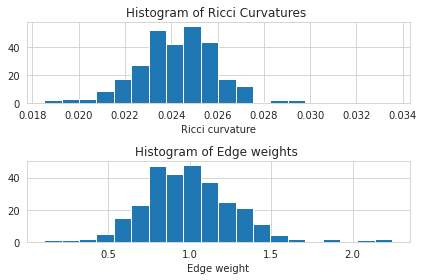

In [0]:
G_rf=riccicomplete(Gred,40,False)

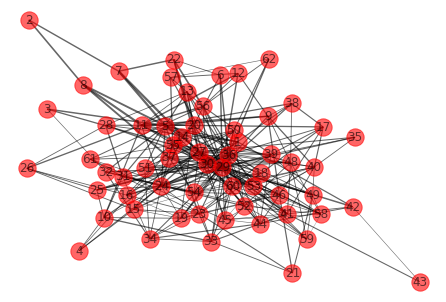

In [0]:
draw_graph(G_rf,1)
plt.savefig('grafocompleto.eps', format='eps')

*************** Surgery time ****************
* Cut 169 edges.
* Number of nodes now: 61
* Number of edges now: 120
* Modularity now: 0.093873 
*********************************************


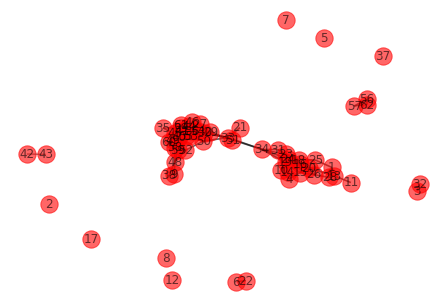

In [0]:
draw_graph(my_surgery(G_rf, cut=0.9),2)
plt.savefig('grafo1.eps', format='eps')

In [0]:
largest_cc = max(nx.connected_components(my_surgery(G_rf, cut=0.9)), key=len) 
# nos quedamos con los nodos de la componente más grande
# creamos el subgrafo sólo con estos componentes
subGred=Gred.subgraph(largest_cc)

*************** Surgery time ****************
* Cut 169 edges.
* Number of nodes now: 61
* Number of edges now: 120
* Modularity now: 0.093873 
*********************************************


In [0]:
len(largest_cc)

45

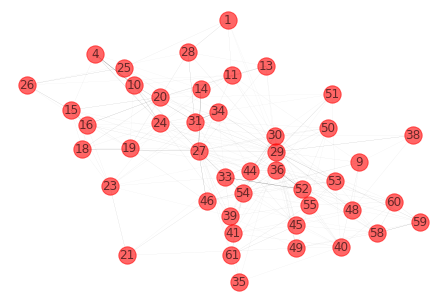

In [0]:
draw_graph(subGred,2)

##############################
#    PROCESO EN EJECUCIÓN    #
##############################

Hora y Fecha: 18:12:4 (1/5/2020)

CALCULO DE CURVATURA OBVIADO

2. CALCULAMOS EL FLUJO: 

2.2. RESULTADOS DEL FLUJO: 

Graph, first 5 edges: 
Ollivier-Ricci curvature of edge (1,11) is 0.049306
Ollivier-Ricci curvature of edge (1,25) is 0.049515
Ollivier-Ricci curvature of edge (1,28) is 0.047809
Ollivier-Ricci curvature of edge (1,29) is 0.045154
Ollivier-Ricci curvature of edge (1,30) is 0.043966

Hora y Fecha: 18:12:42 (1/5/2020)

##############################
#       FIN DEL PROCESO      #
##############################


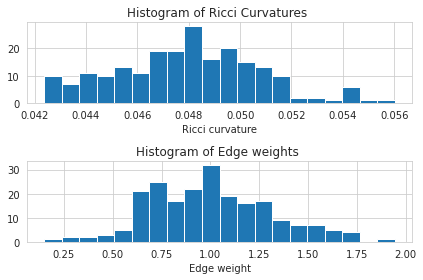

In [0]:
#aplicamos curvatura al nuevo subgrafo
subGrf=riccicomplete(subGred,40,False)

*************** Surgery time ****************
* Cut 177 edges.
* Number of nodes now: 45
* Number of edges now: 38
* Modularity now: 0.323922 
*********************************************


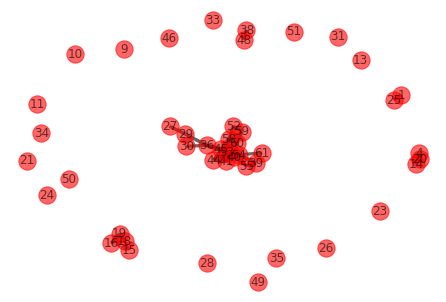

In [0]:
draw_graph(my_surgery(subGrf, cut=0.7),5)
plt.savefig('grafo2.eps', format='eps')

In [0]:
# repetimos
largest_cc = max(nx.connected_components(my_surgery(subGrf, cut=0.7)), key=len) 
# nos quedamos con los nodos de la componente más grande
# creamos el subgrafo sólo con estos componentes
subGred=Gred.subgraph(largest_cc)

*************** Surgery time ****************
* Cut 177 edges.
* Number of nodes now: 45
* Number of edges now: 38
* Modularity now: 0.323922 
*********************************************


##############################
#    PROCESO EN EJECUCIÓN    #
##############################

Hora y Fecha: 18:14:53 (1/5/2020)

CALCULO DE CURVATURA OBVIADO

2. CALCULAMOS EL FLUJO: 

2.2. RESULTADOS DEL FLUJO: 

Graph, first 5 edges: 
Ollivier-Ricci curvature of edge (36,27) is 0.131599
Ollivier-Ricci curvature of edge (36,29) is 0.138984
Ollivier-Ricci curvature of edge (36,30) is 0.130567
Ollivier-Ricci curvature of edge (36,39) is 0.127488
Ollivier-Ricci curvature of edge (36,40) is 0.138522

Hora y Fecha: 18:15:7 (1/5/2020)

##############################
#       FIN DEL PROCESO      #
##############################


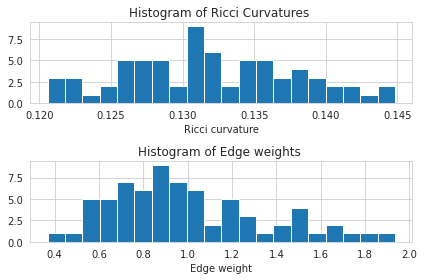

In [0]:
subGrf=riccicomplete(subGred,40,False)

*************** Surgery time ****************
* Cut 57 edges.
* Number of nodes now: 17
* Number of edges now: 13
* Modularity now: 0.253432 
*********************************************


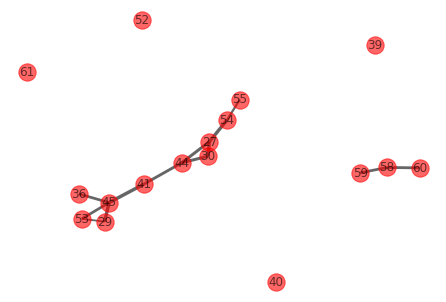

In [0]:
draw_graph(my_surgery(subGrf, cut=0.7),5)
plt.savefig('grafo3.eps', format='eps')

Con esto podemos acabar el análisis.

#### 2.2.2. Louvain

El último algoritmo que consideraremos es más sencillo. Es el algoritmo de Louvain: 

In [0]:
# volvemos a enlacesCOM

Gud=nx.Graph() #creamos el grafo
for i in range(62):
    Gud.add_node(i+1)
for i in range(62):
    for j in range(62):
        Gud.add_edge(i+1,j+1)

enlaces=enlacesCOM.copy()

# sumamos los pesos de los enlaces antiguos
maxim=0
minim=9999999999

for ind1 in enlaces.index: 
    for ind2 in enlaces.index:
        Gud[ind1][ind2]['weight'] = enlaces[str(ind2)][ind1]+enlaces[str(ind1)][ind2]
        if maxim<enlaces[str(ind2)][ind1]+enlaces[str(ind1)][ind2]:
          maxim=enlaces[str(ind2)][ind1]+enlaces[str(ind1)][ind2]
        if minim>enlaces[str(ind2)][ind1]+enlaces[str(ind1)][ind2]:
          minim=enlaces[str(ind2)][ind1]+enlaces[str(ind1)][ind2]



In [0]:
partition = community.best_partition(Gud,weight="weight") #ejecutamos el algoritmo

Devuelve una lista donde indica a qué comunidad pertenece cada nodo, voy a crear una tabla con todas las comunidades.

In [0]:
Comunidades=pd.DataFrame()
Comunidades["Comunidades"]=range(0,62) #max. comunidades
Comunidades=Comunidades.set_index("Comunidades")
ac=[]
for i in range(0,62):
  parcial=[]
  for j in range(1,63):
    if partition[j]==i:
      parcial.append(j)
  ac.append(parcial)
Comunidades["Sectores"]=ac
for i in range(0,62):
  if len(Comunidades["Sectores"][i])==0:
    Comunidades=Comunidades.drop(i)


**Resultado** del algoritmo: Sectores que pertenecen a cada _comunidad_.

In [0]:
Comunidades

,Sectores
Comunidades,
0,"[1, 3, 5, 36, 52]"
1,"[2, 8, 9]"
2,"[4, 10, 24]"
3,[6]
4,"[7, 12, 22, 56]"
5,"[11, 13]"
6,"[14, 27, 46]"
7,"[15, 16, 18, 19, 20]"
8,"[17, 30, 37, 38, 39, 40, 41, 44, 45, 53, 54, 5..."


# Anexo: Predicción de Links

Como se menciona al comienzo no debemos pensar que tratamos de predecir de verdad links futuros, sino obtener de este estudio conexiones entre sectores que no se dan a pesar de que la información de las relaciones de sus vecinos indica una alta probabilidad de que ésta exista.

No está implementado para grafos dirigidos ni con pesos, lo haremos para un grafo donde los enlaces sean _relevantes_, entendiendo como tal $w_{ij}>0.1$. 

_(Nótese que esta vez la motivación es teórica y no computacional como la última reducción de enlaces.)_

Además, como se predecirá con recurrencia links para los enlaces eliminados cercanos a 0.1, buscaremos en los enlaces predichos bajos valores del peso original.

In [3]:
enlaces=pd.read_csv("A_out_com.csv",delimiter=",")
enlaces=enlaces.set_index("ind")
enlaces=enlaces.drop(63)
enlaces=enlaces.drop(64)
enlaces=enlaces.drop('63',axis=1)
enlaces=enlaces.drop('64',axis=1)
Gud=nx.Graph() #creamos el grafo
for i in range(62):
    Gud.add_node(i+1)
for i in range(62):
    for j in range(62):
        Gud.add_edge(i+1,j+1)

# sumamos los pesos de los enlaces antiguos
maxim=0
minim=99999

for ind1 in enlaces.index: 
    for ind2 in enlaces.index:
        Gud[ind1][ind2]['weight'] = enlaces[str(ind2)][ind1]+enlaces[str(ind1)][ind2]
        if maxim<enlaces[str(ind2)][ind1]+enlaces[str(ind1)][ind2]:
          maxim=enlaces[str(ind2)][ind1]+enlaces[str(ind1)][ind2]
        if minim>enlaces[str(ind2)][ind1]+enlaces[str(ind1)][ind2]:
          minim=enlaces[str(ind2)][ind1]+enlaces[str(ind1)][ind2]

# Mejor eliminamos los enlaces con peso 0
maxim=0
minim=9999
for i in range(62):
    for j in range(62):
        try:
          if Gud[i+1][j+1]['weight']==0:
              Gud.remove_edge(i+1,j+1)
          else:
              if maxim<Gud[i+1][j+1]['weight']:
                  maxim=Gud[i+1][j+1]['weight']
              if minim>Gud[i+1][j+1]['weight']:
                  minim=Gud[i+1][j+1]['weight']

        except:
          bluf=0

#normalizo entre 0 y 1, para aumentar la varianza en los algoritmos
for i in range(62):
    for j in range(62):
        try:
          Gud[i+1][j+1]['weight']=(Gud[i+1][j+1]['weight']-minim)/(maxim-minim)

        except:
          bluf=0


# creamos el grafo reducido w>0.1
Glink=Gud.copy() 
count=0
for i in range(62):
    for j in range(62):
        try:
          if Glink[i+1][j+1]['weight']<0.1:
              Glink.remove_edge(i+1,j+1)
              count=count+1
        except:
          bluf=-1
print("Eliminados "+str(count)+" enlaces.")
print("Nos quedamos con los "+str(Glink.number_of_edges())+" enlaces más relevantes.")

Eliminados 1836 enlaces.
Nos quedamos con los 53 enlaces más relevantes.


### 3.1. Adamic Adar

El primer método será el Adamic Adar ...

In [0]:
prediccionesAA=pd.DataFrame(nx.adamic_adar_index(Glink))
prediccionesAA.columns=["Nodo1","Nodo2","AdamicAdar"]

### 3.2. Preferential Attachment

El segundo método será Preferential Attachment

In [0]:
prediccionesPA=pd.DataFrame(nx.preferential_attachment(Glink))
prediccionesPA.columns=["Nodo1","Nodo2","PrefAtt"]

### 3.3. Análisis 

El primer método será el Adamic Adar ...

In [0]:
predicciones=prediccionesAA.copy()
predicciones["PrefAtt"]=prediccionesPA["PrefAtt"]
#creo una variable que me diga si el enlace existió originalmente
#con menos de 0.1 de peso (marginal)
ac=[]
for i in predicciones.index:
  n1=predicciones["Nodo1"][i]
  n2=predicciones["Nodo2"][i]
  try:
      w=Gud[n1][n2]["weight"]
      if w<0.005:
        ac.append(1)
      else:
        ac.append(0)
  except:
      ac.append(1)
predicciones["Original"]=ac

predicciones=predicciones.set_index(["Nodo1","Nodo2"])
predicciones

AdamicAdar  PrefAtt  Original
Nodo1 Nodo2                               
1     2        0.000000        2         1
      3        0.721348        3         1
      4        0.000000        1         1
      6        0.000000        2         0
      7        0.000000        2         1
...                 ...      ...       ...
59    61       0.000000        4         1
      62       0.000000        4         1
60    61       0.000000        0         1
      62       0.000000        0         1
61    62       0.000000        4         1

[1883 rows x 3 columns]

In [0]:
#vemos la correlación
predicciones.corr(method="pearson") #no hay demasiada correlación, sí es
                                     #positiva con el hecho de que existiera
                                     #relación pasada (bien!)

,AdamicAdar,PrefAtt,Original
AdamicAdar,1.000000,-0.011161,0.022081
PrefAtt,-0.011161,1.000000,0.083722
Original,0.022081,0.083722,1.000000


In [0]:
# normalizo como usualmente entre 0 y 1 para crear una medida
# conjunta de AA y PA (la multiplicación)
maximo=predicciones["AdamicAdar"].max()
minimo=predicciones["AdamicAdar"].min()
maximo2=predicciones["PrefAtt"].max()
minimo2=predicciones["PrefAtt"].min()
ac=[]
ac2=[]
for i,j in zip(predicciones["AdamicAdar"],predicciones["PrefAtt"]):
  ac.append((i-minimo)/(maximo-minimo))
  ac2.append((j-minimo2)/(maximo2-minimo2))
predicciones["AANorm"]=ac
predicciones["PANorm"]=ac2
predicciones["Conjunta"]=np.array(ac)*np.array(ac2)

In [0]:
predicciones.sort_values("Conjunta",ascending=False).head()

AdamicAdar  PrefAtt  Original  AANorm  PANorm  Conjunta
Nodo1 Nodo2                                                         
1     3        0.721348        3         1     1.0  0.1875    0.1875
33    36       0.721348        1         1     1.0  0.0625    0.0625
26    58       0.000000        4         1     0.0  0.2500    0.0000
27    34       0.000000        6         0     0.0  0.3750    0.0000
      33       0.000000        3         1     0.0  0.1875    0.0000

In [0]:
predicciones.sort_values("AdamicAdar",ascending=False).head() #1-3 33-36

AdamicAdar  PrefAtt  Original  AANorm  PANorm  Conjunta
Nodo1 Nodo2                                                         
1     3        0.721348        3         1     1.0  0.1875    0.1875
33    36       0.721348        1         1     1.0  0.0625    0.0625
26    58       0.000000        4         1     0.0  0.2500    0.0000
27    34       0.000000        6         0     0.0  0.3750    0.0000
      33       0.000000        3         1     0.0  0.1875    0.0000

In [0]:
predicciones.sort_values("PrefAtt",ascending=False).head() #reforzar el triangulo 5-12-52

AdamicAdar  PrefAtt  Original  AANorm  PANorm  Conjunta
Nodo1 Nodo2                                                         
5     52            0.0       16         1     0.0    1.00       0.0
12    52            0.0       12         1     0.0    0.75       0.0
5     12            0.0       12         0     0.0    0.75       0.0
      42            0.0       12         1     0.0    0.75       0.0
      43            0.0       12         1     0.0    0.75       0.0

Estudio de los sectores 36 y 52.

Enlaces más importantes para ambos:

In [35]:
### RECUPERAMOS EL GRAFO BASADO EN A_OUT con aij=1/aij
enlaces=pd.read_csv("A_out_com.csv",delimiter=",")
enlaces=enlaces.set_index("ind")
enlaces=enlaces.drop(63)
enlaces=enlaces.drop(64)
enlaces=enlaces.drop(47)
enlaces=enlaces.drop('63',axis=1)
enlaces=enlaces.drop('64',axis=1)
enlaces=enlaces.drop('47',axis=1)
# se eliminan los nodos sin enlaces
# tenemos que pasar todo a float
for i in enlaces.index:
  for j in enlaces.columns:
    cad=str(enlaces[j][i])
    cad=cad.replace(",","")
    v=float(cad)
    try:
      enlaces[j][i]=1/v
    except:
      enlaces[j][i]=0
G=nx.Graph() #creamos el grafo
for i in range(62):
  if (i!=47):
    G.add_node(i+1)
for i in range(62):
  if (i!=46):
    for j in range(62):
      if (j!=46):
        G.add_edge(i+1,j+1)
G=nx.DiGraph(G) #lo hacemos dirigido
# add weights a_ij=sales_ji/sales_i
# lo que busco es que A-w->B lo que vende A a B en w.

for ind1 in enlaces.index: 
    for ind2 in enlaces.index:
        G[ind1][ind2]['weight'] = enlaces[str(ind2)][ind1]
# Mejor eliminamos los enlaces con peso 0
for i in range(62):
  if (i!=46):
    for j in range(62):
      if (j!=46):
        if G[i+1][j+1]['weight']==0:
            G.remove_edge(i+1,j+1)

print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 62
Number of edges: 3315
Average in degree:  53.4677
Average out degree:  53.4677


In [40]:
betweenness

{(1, 1): 0.0,
 (1, 2): 0.0007565322505285795,
 (1, 4): 0.0004886319925431483,
 (1, 5): 0.0004784186653674856,
 (1, 6): 0.0005040403325699689,
 (1, 7): 0.00047088444835456753,
 (1, 8): 0.0005095218048361749,
 (1, 11): 0.000535280596125974,
 (1, 12): 0.0004241964939451686,
 (1, 13): 0.000495831616207099,
 (1, 17): 0.0005382031813445112,
 (1, 19): 0.0005006506454925257,
 (1, 21): 0.0004944742951442051,
 (1, 22): 0.0005137206195332308,
 (1, 26): 0.0005357548166070893,
 (1, 27): 0.0005357548166070893,
 (1, 29): 0.0005357548166070893,
 (1, 30): 0.0005357548166070893,
 (1, 34): 0.0005559528305914596,
 (1, 36): 0.0005357548166070893,
 (1, 41): 0.000601301970456877,
 (1, 42): 0.0006331422617669585,
 (1, 43): 0.0005496711516011053,
 (1, 45): 0.0005496711516011053,
 (1, 49): 0.0005389481785018514,
 (1, 53): 0.0005420503014853346,
 (1, 54): 0.0005237361636577119,
 (1, 55): 0.0005496711516011053,
 (1, 56): 0.000550250315129091,
 (1, 57): 0.0003386219220375675,
 (1, 58): 0.0004834162927884145,
 (1, 

In [0]:
betweenness=nx.edge_betweenness_centrality(G,weight="weight")

In [42]:
sectores=[36,52] # de salida
for i in sectores:
  for j in range(1,63):
    try:
      print(str(i)+", "+str(j))
      print(betweenness[(i,j)])
      print()
    except:
      a=0

36, 1
0.0

36, 2
36, 3
0.0

36, 4
0.0

36, 5
0.0

36, 6
0.0

36, 7
0.0

36, 8
0.0

36, 9
0.0

36, 10
0.0

36, 11
0.0

36, 12
0.0

36, 13
0.0

36, 14
0.0

36, 15
0.0

36, 16
0.0

36, 17
0.0

36, 18
0.0

36, 19
0.0

36, 20
0.0

36, 21
0.0

36, 22
0.0

36, 23
0.0

36, 24
0.0

36, 25
0.0

36, 26
0.0

36, 27
0.0

36, 28
0.0

36, 29
0.0

36, 30
0.0

36, 31
0.0

36, 32
0.0

36, 33
0.0

36, 34
0.0

36, 35
0.0

36, 36
0.0

36, 37
0.0

36, 38
0.0

36, 39
0.0

36, 40
0.025647805393971445

36, 41
0.0

36, 42
0.0

36, 43
0.0

36, 44
0.0

36, 45
0.0

36, 46
0.007403490216816499

36, 47
36, 48
0.0

36, 49
0.0

36, 50
0.0

36, 51
0.0

36, 52
0.09492332099418298

36, 53
0.0

36, 54
0.0

36, 55
0.0

36, 56
0.003966155473294554

36, 57
0.0

36, 58
0.0

36, 59
0.0

36, 60
0.1195134849286092

36, 61
0.0

36, 62
0.0

52, 1
52, 2
52, 3
0.0

52, 4
0.0

52, 5
0.0

52, 6
0.0

52, 7
0.0

52, 8
0.0

52, 9
0.0

52, 10
0.0

52, 11
0.0

52, 12
0.0

52, 13
0.0

52, 14
0.0

52, 15
52, 16
0.0

52, 17
0.0

52, 18
0.0

5

In [43]:
sectores=[36,52] # de entrada
for i in sectores:
  for j in range(1,63):
    try:
      print(str(j)+", "+str(i))
      print(betweenness[(j,i)])
      print()
    except:
      a=0

1, 36
0.0

2, 36
0.0

3, 36
0.0

4, 36
0.0

5, 36
0.18112109994711792

6, 36
0.007932310946589107

7, 36
0.0

8, 36
0.0

9, 36
0.0

10, 36
0.0

11, 36
0.0

12, 36
0.0

13, 36
0.0

14, 36
0.0

15, 36
0.0

16, 36
0.0

17, 36
0.0031729243786356425

18, 36
0.0

19, 36
0.008461131676361713

20, 36
0.0

21, 36
0.0

22, 36
0.0

23, 36
0.0

24, 36
0.006081438392384982

25, 36
0.006081438392384982

26, 36
0.0

27, 36
0.0

28, 36
0.0

29, 36
0.0

30, 36
0.0

31, 36
0.0

32, 36
0.0

33, 36
0.0

34, 36
0.0

35, 36
0.0

36, 36
0.0

37, 36
0.0

38, 36
0.0

39, 36
0.004230565838180857

40, 36
0.0

41, 36
0.0

42, 36
0.0

43, 36
0.0

44, 36
0.008461131676361713

45, 36
0.0

46, 36
0.0

47, 36
48, 36
0.0

49, 36
0.0

50, 36
0.0

51, 36
0.0

52, 36
0.0

53, 36
0.0

54, 36
0.017451084082496033

55, 36
0.0

56, 36
0.0

57, 36
0.0

58, 36
0.006081438392384982

59, 36
0.0

60, 36
0.0

61, 36
0.0013220518244315177

62, 36
0.0010576414595452142

1, 52
2, 52
3, 52
4, 52
5, 52
0.0

6, 52
0.0

7, 52
8, 52
0.0

9

### Alluvial diagram

Reducimos la base de datos a las columnas y las filas referentes a hosteleria (36) y turismo (52).

In [115]:
### RECUPERAMOS EL GRAFO BASADO EN weights normal
enlaces=pd.read_csv("weights.csv",delimiter=";")
enlaces=enlaces.set_index("ind")
enlaces=enlaces.drop(63)
enlaces=enlaces.drop(64)
enlaces=enlaces.drop(47)
enlaces=enlaces.drop('63',axis=1)
enlaces=enlaces.drop('64',axis=1)
enlaces=enlaces.drop('47',axis=1)
# se eliminan los nodos sin enlaces
# tenemos que pasar todo a float
for i in enlaces.index:
  for j in enlaces.columns:
    cad=str(enlaces[j][i])
    cad=cad.replace(",","")
    v=float(cad)
    try:
      enlaces[j][i]=v
    except:
      enlaces[j][i]=0
G=nx.Graph() #creamos el grafo
for i in range(62):
  if (i!=47):
    G.add_node(i+1)
for i in range(62):
  if (i!=46):
    for j in range(62):
      if (j!=46):
        G.add_edge(i+1,j+1)
G=nx.DiGraph(G) #lo hacemos dirigido
# add weights a_ij=sales_ji/sales_i
# lo que busco es que A-w->B lo que vende A a B en w.

for ind1 in enlaces.index: 
    for ind2 in enlaces.index:
        G[ind1][ind2]['weight'] = enlaces[str(ind2)][ind1]
# Mejor eliminamos los enlaces con peso 0
for i in range(62):
  if (i!=46):
    for j in range(62):
      if (j!=46):
        if G[i+1][j+1]['weight']==0:
            G.remove_edge(i+1,j+1)

print(nx.info(G))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Name: 
Type: DiGraph
Number of nodes: 62
Number of edges: 3315
Average in degree:  53.4677
Average out degree:  53.4677


In [92]:
enlaces[50:55]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
ind,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
52,0,0.0,3.0,0.5,1.5,3.4,0.1,0.2,0.7,4.7,14.7,8.2,1.9,0.4,0,3.3,2.8,0.1,1.8,5.1,1.6,0.9,15,5,3.9,16.6,171.2,36.7,72.9,28.3,24.2,0.6,85.5,41.2,0,13.2,43.0,7.9,6.5,166.9,4.6,1.8,2.4,10.2,2.3,27.5,98.5,31.8,212.1,2.3,1416.9,19.7,27.9,11.9,9.2,0.0,0.9,14.0,3.9,3.7,1.6
53,89.2,0.0,5.5,98.9,1115.4,179.8,60.9,212.1,154.0,199.1,503.1,181.9,237.1,135.6,122.2,300,107.2,229.2,240.4,775.7,185.8,16.9,352,1173,355.2,184.8,1882.8,579.7,6057.4,2974.4,1265.6,34.2,179.7,1467.3,82.2,796.3,146.4,41.7,902.1,1887.2,1532.5,232.6,615.8,922.1,1971.3,739.1,227.2,128.9,177.2,29.1,234,5959.4,2399.8,872.4,1558.4,750.5,19.1,275.5,118.9,35.5,287.6
54,5,0.0,27.9,3.6,20.7,7.2,2.1,3.3,4.0,0,6.3,19.7,10,6.1,17.1,17,2.1,8.3,6.4,20.4,7.2,4.5,14.1,44.8,2.4,8.8,293,1.9,89.2,252.9,51.1,13.5,51.2,49,5.4,177,6.8,1.1,17.4,11.1,0,0,0.2,4.4,7.9,3.7,17,6.7,18.8,3.9,12.3,26.9,10.8,101.0,27.7,43.1,10.6,16.9,1.7,3.5,4.8
55,6.5,0.0,0.9,4.4,128.3,19.7,0.9,6.7,19.3,64.6,24.1,56.8,35.4,5.2,60.9,10.8,25.3,8.3,28.9,125.2,39.9,18.6,75.3,178.2,31.3,62.9,155.8,150.9,372,314.1,91.2,0.8,150.3,3.4,0.2,51.6,68.9,11,336.4,326.4,50.3,0.2,21.5,44.6,91.7,89,111.9,81,41.8,21.6,2.9,212.5,26.7,139.5,36.6,139.9,1.1,6.1,325.2,18.5,16.1
56,0,0.0,2.1,5.0,95.6,14.4,0.4,2.3,2.9,14.2,38.3,18.8,8.9,2.3,1.6,1.7,6.6,12.4,11.9,62.5,20.3,20.7,49.4,53.9,14.1,95.1,0.8,134.3,961.2,404.1,79.2,0.7,0,1.4,22,345.5,10.9,7.6,292.9,122.2,46.4,7.1,21.8,38.6,98,82.9,50.5,36.7,15.8,9.1,0.1,94.7,35.6,46.2,4309.3,106.6,10.1,25.8,144.5,7.5,17.0


In [0]:
enlacesentrada=enlaces[(enlaces.index==52)|(enlaces.index==36)]
enlacessalida=enlaces[["36","52"]]

In [94]:
enlacesentrada.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
ind,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
36,1,0.0,5.3,2.8,16.1,4.7,2.4,2.3,2.0,9.7,78.6,8.7,24.2,2.6,11.4,31.9,7.0,3,23.2,29.7,19.9,4.1,13.1,12.2,5.3,70.5,466.5,28.4,225,82.7,320.2,1.3,12.7,63.3,8.6,733.6,42.1,43.8,13.4,832.4,348.3,90.5,142.6,76.1,227.5,327.9,62.5,36.6,17.3,8.0,6151.1,102.7,354.8,178.8,487.9,91.4,20.3,24.3,845.0,11.6,14.3
52,0,0.0,3.0,0.5,1.5,3.4,0.1,0.2,0.7,4.7,14.7,8.2,1.9,0.4,0,3.3,2.8,0.1,1.8,5.1,1.6,0.9,15,5,3.9,16.6,171.2,36.7,72.9,28.3,24.2,0.6,85.5,41.2,0,13.2,43.0,7.9,6.5,166.9,4.6,1.8,2.4,10.2,2.3,27.5,98.5,31.8,212.1,2.3,1416.9,19.7,27.9,11.9,9.2,0.0,0.9,14.0,3.9,3.7,1.6


In [0]:
sources=[]
targets=[]
values=[]
for i in enlacesentrada.index:
  for j in enlacesentrada.columns:
    v=float(enlacesentrada[j][i])
    if v>150:
      sources.append(i)
      targets.append(j)
      values.append(v)

In [0]:
    link = dict(
      source = sources,
      target = targets,
      value = values)

In [113]:
fig = go.Figure(data=[go.Sankey(arrangement = "freeform",
    node = dict(
      pad = 1,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = list(range(0,62)),
      color = "blue"
    ),
    link = dict(
      source = sources,
      target = targets,
      value = values
  ))])

fig.update_layout(title_text="", font_size=10)
fig.show()

In [116]:
### RECUPERAMOS EL GRAFO BASADO EN weights normal
enlaces=pd.read_csv("weights.csv",delimiter=";")
enlaces=enlaces.set_index("ind")
enlaces=enlaces.drop(63)
enlaces=enlaces.drop(64)
enlaces=enlaces.drop(47)
enlaces=enlaces.drop('63',axis=1)
enlaces=enlaces.drop('64',axis=1)
enlaces=enlaces.drop('47',axis=1)
# se eliminan los nodos sin enlaces
# tenemos que pasar todo a float
for i in enlaces.index:
  for j in enlaces.columns:
    cad=str(enlaces[j][i])
    cad=cad.replace(",","")
    v=float(cad)
    try:
      enlaces[j][i]=v
    except:
      enlaces[j][i]=0
G=nx.Graph() #creamos el grafo
for i in range(62):
  if (i!=47):
    G.add_node(i+1)
for i in range(62):
  if (i!=46):
    for j in range(62):
      if (j!=46):
        G.add_edge(i+1,j+1)
G=nx.DiGraph(G) #lo hacemos dirigido
# add weights a_ij=sales_ji/sales_i
# lo que busco es que A-w->B lo que vende A a B en w.

for ind1 in enlaces.index: 
    for ind2 in enlaces.index:
        G[ind1][ind2]['weight'] = enlaces[str(ind2)][ind1]
# Mejor eliminamos los enlaces con peso 0
for i in range(62):
  if (i!=46):
    for j in range(62):
      if (j!=46):
        if G[i+1][j+1]['weight']==0:
            G.remove_edge(i+1,j+1)

print(nx.info(G))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Name: 
Type: DiGraph
Number of nodes: 62
Number of edges: 3315
Average in degree:  53.4677
Average out degree:  53.4677


In [117]:
sg=G.copy() ### OJO ESTE ES CON 300
factor_importancia=1900
for i in range(1,63):
  for j in range(1,63):
    try:
      if sg.edges[i,j]["weight"]<factor_importancia:
        sg.remove_edge(i,j)
    except:
      adsfrfwadse=0
print(len(sg.edges)) #pasamos de +3800 a estos enlaces (más importantes)
subG=nx.ego_graph(sg,36,1,undirected=True)

81


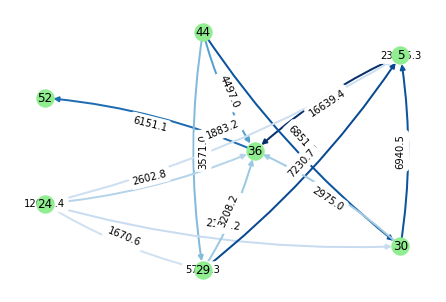

In [146]:
edges,weights = zip(*nx.get_edge_attributes(subG,'weight').items())
weights=np.array(weights)

cmap = mpl.cm.Blues(np.linspace(0,3,150))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])
pos=nx.circular_layout(subG)
pos[36]=np.array([0,0])
labels = nx.get_edge_attributes(subG,'weight')
for key, value in labels.items():
    labels[key] = round(value,2)
nx.draw(subG,pos=pos, node_color='lightgreen', connectionstyle='arc3, rad = 0.08',edgelist=edges, edge_color=weights, width=2.0, edge_cmap=cmap, with_labels = True)
nx.draw_networkx_edge_labels(subG,pos,edge_labels=labels)
plt.savefig('edges36.eps', format="eps")

In [147]:
sg=G.copy()
factor_importancia=1500
for i in range(1,63):
  for j in range(1,63):
    try:
      if sg.edges[i,j]["weight"]<factor_importancia:
        sg.remove_edge(i,j)
    except:
      adsfrfwadse=0
len(sg.edges) #pasamos de +3800 a estos enlaces (más importantes)

112

In [0]:
subG=nx.ego_graph(sg,52,2,undirected=True)

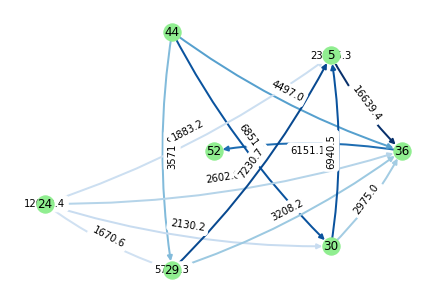

In [151]:
edges,weights = zip(*nx.get_edge_attributes(subG,'weight').items()) #construida egonet de 2, lo más importante es lo que le ocurra al 36
weights=np.array(weights)

cmap = mpl.cm.Blues(np.linspace(0,3,150))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])
pos=nx.circular_layout(subG)
pos[52]=np.array([0,0])
pos[33]=np.array([-0.5,-0.9])
labels = nx.get_edge_attributes(subG,'weight')
for key, value in labels.items():
    labels[key] = round(value,2)
nx.draw(subG,pos=pos, node_color='lightgreen', connectionstyle='arc3, rad = 0.08',edgelist=edges, edge_color=weights, width=2.0, edge_cmap=cmap, with_labels = True)
nx.draw_networkx_edge_labels(subG,pos,edge_labels=labels)
plt.savefig('edges52.eps', format='eps')


In [0]:
enlaces

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
ind,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,871,0.1,0.0,0.2,27665.3,674.2,3.7,23.8,0.0,0,484.8,149.7,199.4,0,0,0,0.2,0,9.2,0,0.1,7.5,0,0,0,7.1,13.7,0,259.9,60.7,0,0.0,0,9.9,0,587.8,0.0,0,0,0,0.5,0.1,1.2,0,8.4,0,0,7.3,0,0.0,0,65.4,92.1,112.5,60.1,20.2,2.3,25.4,0.8,0.0,0.0
2,10.4,796.7,0.0,1.2,25.7,0,72.9,227,0.0,0,2.8,6.2,36.5,0,0,0,0.0,0,0.3,0,0,20.8,0,38.1,0,2.7,1.5,0,10.4,0.5,0,0.0,0,0,0,12.1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.8,8.6,0.0,0,0.0,0.3,0.0,0.0,0.0,0.0
3,0,0.0,44.6,0.0,203.3,0,0,0,0.0,0,0,0.1,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.3,0,2.6,0.3,0,0.0,0,0,0,3.5,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,6,21.3,5.9,9.5,0.3,0.0,0.0,0.0,0.0
4,0,0.0,3.0,53.1,94,2.6,0.3,71.3,1.7,16960.4,420,12.1,2.8,965.5,2091.3,102.1,0.3,445.3,22,77.8,0,7.8,32.3,5707.2,7.8,34.7,536,0.3,299.2,3.3,0.1,0.0,0,3.7,0,23.1,0.9,0.1,0.1,6.8,0.6,0.2,0.7,4.4,39.3,0.7,0.2,0,3.4,0.1,0,2.6,16.6,0.5,0,0.0,1.3,3.2,0.0,0.1,0.8
5,7371.8,0.7,164.3,20.5,23595.3,194.5,0.1,58.8,0.0,8.8,291.1,285,2,0.1,0,0.2,0.2,1.7,10.6,0,0,3.9,49.9,461,90.7,2.4,79.4,5.6,1110.9,606.4,8.6,0.0,0,36.9,0.5,16639.4,0.4,1.8,3.1,3.5,4.2,0.2,3.8,31.4,34.5,4.8,1.3,21.9,18.5,0.2,1.1,12.1,312.7,327.2,394.3,382.3,212.6,225.5,11.8,0.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,1,0.0,1.5,0.1,20.1,0.2,0.1,0,4.5,7,6.4,11.7,0,0,0.2,0,2.7,0,7.3,18.1,4,0.2,39.6,0,0.1,0.6,0.2,0.6,99.9,10.3,32.8,0.0,20.2,0,17.3,242.6,62.7,53.1,49.9,0.3,26.4,3,11.8,8.3,107.2,86,109.8,74.3,46.7,14.0,93.4,135.7,10.5,6.1,0,0.0,432.4,215.8,4.3,0.7,17.0
59,0,0.0,0.7,0.1,63.2,7.2,0,4.1,4.6,74.7,8.7,8,10.5,0,15,9.5,13.6,0.1,20.3,44,50.8,37.9,67.5,0,0.2,13.9,0.6,53,580.3,14,0,0.0,0,73.7,49.7,174.7,130.4,102.5,176,0.6,90.6,9.2,40.1,92.2,137.8,38.9,179.7,144.1,101.6,27.9,401.2,227.1,30.4,14.7,0,3.9,953.5,878.3,99.6,6.0,2.8
60,8,0.0,30.3,0.6,78.6,4.2,6.5,10.5,1.0,35.6,128.3,40.9,8.7,37.7,28.5,51.5,4.0,8.2,15.6,84.7,8.6,37.5,33.7,225.4,5.9,84.8,1,105.3,431.5,207,196.4,5.8,0,31.2,0.1,163.1,14.8,23.9,38.8,480.7,87.4,4.7,38.5,122.4,300.5,217.6,102.2,97.4,18.8,26.9,0,160.3,17.2,74.0,17.2,357.6,815.1,575.7,639.7,19.9,10.6


In [0]:
h

In [0]:
Gmini=nx.DiGraph() #minigrafo...

In [0]:
Gmini.add_node(1)
Gmini.add_node(5)

In [0]:
Gmini.add_edge(1,5,weight=27665)
Gmini.add_edge(5,1,weight=7371)

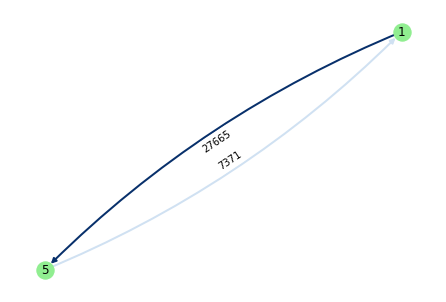

In [0]:
edges,weights = zip(*nx.get_edge_attributes(Gmini,'weight').items()) #construida egonet de 2, lo más importante es lo que le ocurra al 36
weights=np.array(weights)

cmap = mpl.cm.Blues(np.linspace(0,3,150))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])
pos=nx.circular_layout(Gmini)
pos[1]=np.array([1,0])
pos[5]=np.array([-0.6,-0.8])
labels = {(1, 5): 27665, (5, 1): "27665\n\n7371"}
for key, value in labels.items():
    labels[key] = value
nx.draw(Gmini,pos=pos, node_color='lightgreen', connectionstyle='arc3, rad = 0.1',edgelist=edges, edge_color=weights, width=2.0, edge_cmap=cmap, with_labels = True)
nx.draw_networkx_edge_labels(Gmini,pos,edge_labels=labels)
plt.savefig('edges.eps', format='eps')

In [0]:
labels

{(1, 5): 27665, (5, 1): 7371}